
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Supplementary Figures 1-6
-----

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

-----
##### Set up input / output directories

In [4]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

-----
##### Load helper scripts

In [5]:
sys.path.append(str(root_dir))
import scripts.plotter as plotter
import scripts.utils as ut

-----
##### Load & prepare data 

In [ ]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md.txt'), sep='\t', index_col=0)
low_samples = kzm611_md[kzm611_md.Burden=='low'].index.tolist()

-----------
## Supplementary Figures 1-3

In [6]:
## Load signatures
kzm611_sigs = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_signatures.tsv'), sep='\t', index_col=0)
kzm611_sigs_rel = kzm611_sigs.div(kzm611_sigs.sum(axis=1), axis=0)
kzm611_sigs_low = kzm611_sigs.loc[low_samples].copy()

kzm611_sigs_01 = kzm611_sigs.copy()
kzm611_sigs_01 = kzm611_sigs_01.apply(lambda x: [1 if y > 0 else 0 for y in x])
kzm611_sigs_01.columns = [x.replace('/', '') for x in kzm611_sigs_01.columns]

cnv_sigs = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_CN48_sigs.txt'), sep='\t', index_col=0)
sv_sigs = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_SV32_sigs.txt'), sep='\t', index_col=0)

sv_sigs_01 = sv_sigs.apply(lambda x: [1 if y > 0 else 0 for y in x])
cnv_sigs_01 = cnv_sigs.apply(lambda x: [1 if y > 0 else 0 for y in x])

kzm_all_sigs_01 = pd.concat([kzm611_sigs_01, sv_sigs_01, cnv_sigs_01], axis=1)
kzm_low_sigs_01 = kzm_all_sigs_01.loc[low_samples].copy()

In [7]:
kzm_all_sigs_01_cp = kzm_all_sigs_01.copy().fillna(0)
kzm_all_sigs_01_cp.head(2)

,SBS1,SBS2,SBS5,SBS7a,SBS7b,SBS8,SBS10a,SBS10b,SBS11,SBS12,...,CN7,CN13,CN20,CN25,CN48A,CN48B,CN48C,CN48D,CN48E,CN48F
I-H-108298-T1-1-D1-1,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
I-H-108317-T1-1-D1-1,1,0,1,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
kzm_all_sigs_01[(kzm_all_sigs_01.SBS1>0) & (kzm_all_sigs_01.SBS5>0)].shape

(430, 95)

In [ ]:



# Calculate pairwise p-values using Chi-Square test
features = kzm_all_sigs_01_cp.columns
p_values = []
pairs = []

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        if i < j:  # Avoid redundant calculations and diagonal
            contingency_table = pd.crosstab(kzm_all_sigs_01_cp[feature1], kzm_all_sigs_01_cp[feature2])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            pairs.append((feature1, feature2))
            p_values.append(p)

# Create a DataFrame for results
results = pd.DataFrame(pairs, columns=['Feature1', 'Feature2'])
results['p_value'] = p_values
print("Initial Pairwise P-Values:\n", results.head(3))

# Adjust p-values for multiple testing using FDR
adjusted_p = multipletests(results['p_value'], method='fdr_bh')[1]
results['adjusted_p'] = adjusted_p

# Filter for significant interactions (adjusted p < 0.05)
significant_results = results[results['adjusted_p'] < 0.05]
print("Significant Interactions:\n", significant_results.head(3))

# Prepare interaction matrix for heatmap
interaction_matrix = pd.DataFrame(0.0, index=features, columns=features)

for _, row in significant_results.iterrows():
    interaction_matrix.loc[row['Feature1'], row['Feature2']] = -np.log10(row['adjusted_p'])
    interaction_matrix.loc[row['Feature2'], row['Feature1']] = -np.log10(row['adjusted_p'])

# Plot heatmap
'''plt.figure(figsize=(18, 18))
sns.heatmap(interaction_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': '-log10(p-value)'})
plt.title("Significant Feature Interactions (FDR Adjusted)")
plt.show()'''


Initial Pairwise P-Values:
   Feature1 Feature2   p_value
0     SBS1     SBS2  0.016008
1     SBS1     SBS5  0.000133
2     SBS1    SBS7a  1.000000
Significant Interactions:
    Feature1 Feature2       p_value  adjusted_p
1      SBS1     SBS5  1.328543e-04    0.002684
4      SBS1     SBS8  5.835851e-08    0.000002
16     SBS1    SBS31  3.594836e-05    0.000811


'plt.figure(figsize=(18, 18))\nsns.heatmap(interaction_matrix, annot=True, cmap=\'coolwarm\', cbar_kws={\'label\': \'-log10(p-value)\'})\nplt.title("Significant Feature Interactions (FDR Adjusted)")\nplt.show()'

In [285]:
kzm_all_sigs_01_cp2 = kzm_all_sigs_01_cp.copy()
kzm_all_sigs_01_cp2['AM'] = kzm_all_sigs_01_cp2['SBS17b'] + kzm_all_sigs_01_cp2['SBS87']

In [9]:
artifact_sigs = ['SBS43','SBS45','SBS46','SBS53','SBS54','SBS57','SBS60']


In [280]:
interaction_matrix.shape, interaction_matrix.drop(artifact_sigs, axis=1).drop(artifact_sigs, axis=0).shape

((95, 95), (88, 88))

In [11]:
interaction_mat_noArtifact = interaction_matrix.drop(artifact_sigs, axis=1).drop(artifact_sigs, axis=0).copy()

In [13]:
sbs_cosigs = ['SBS11', 'SBS17b', 'SBS31', 'SBS35', 'SBS87', 'SBS288L2', 'SBS288L4', 'SBS288L5']
dbs_cosigs = ['DBS2', 'DBS5', 'DBS6', 'DBS78H2', 'ID3', 'ID5', 'ID8', 'ID17']
svcn_cosigs = ['SV2', 'SV4', 'SV6', 'SV9', 'CN3', 'CN5', 'CN7', 'CN20']

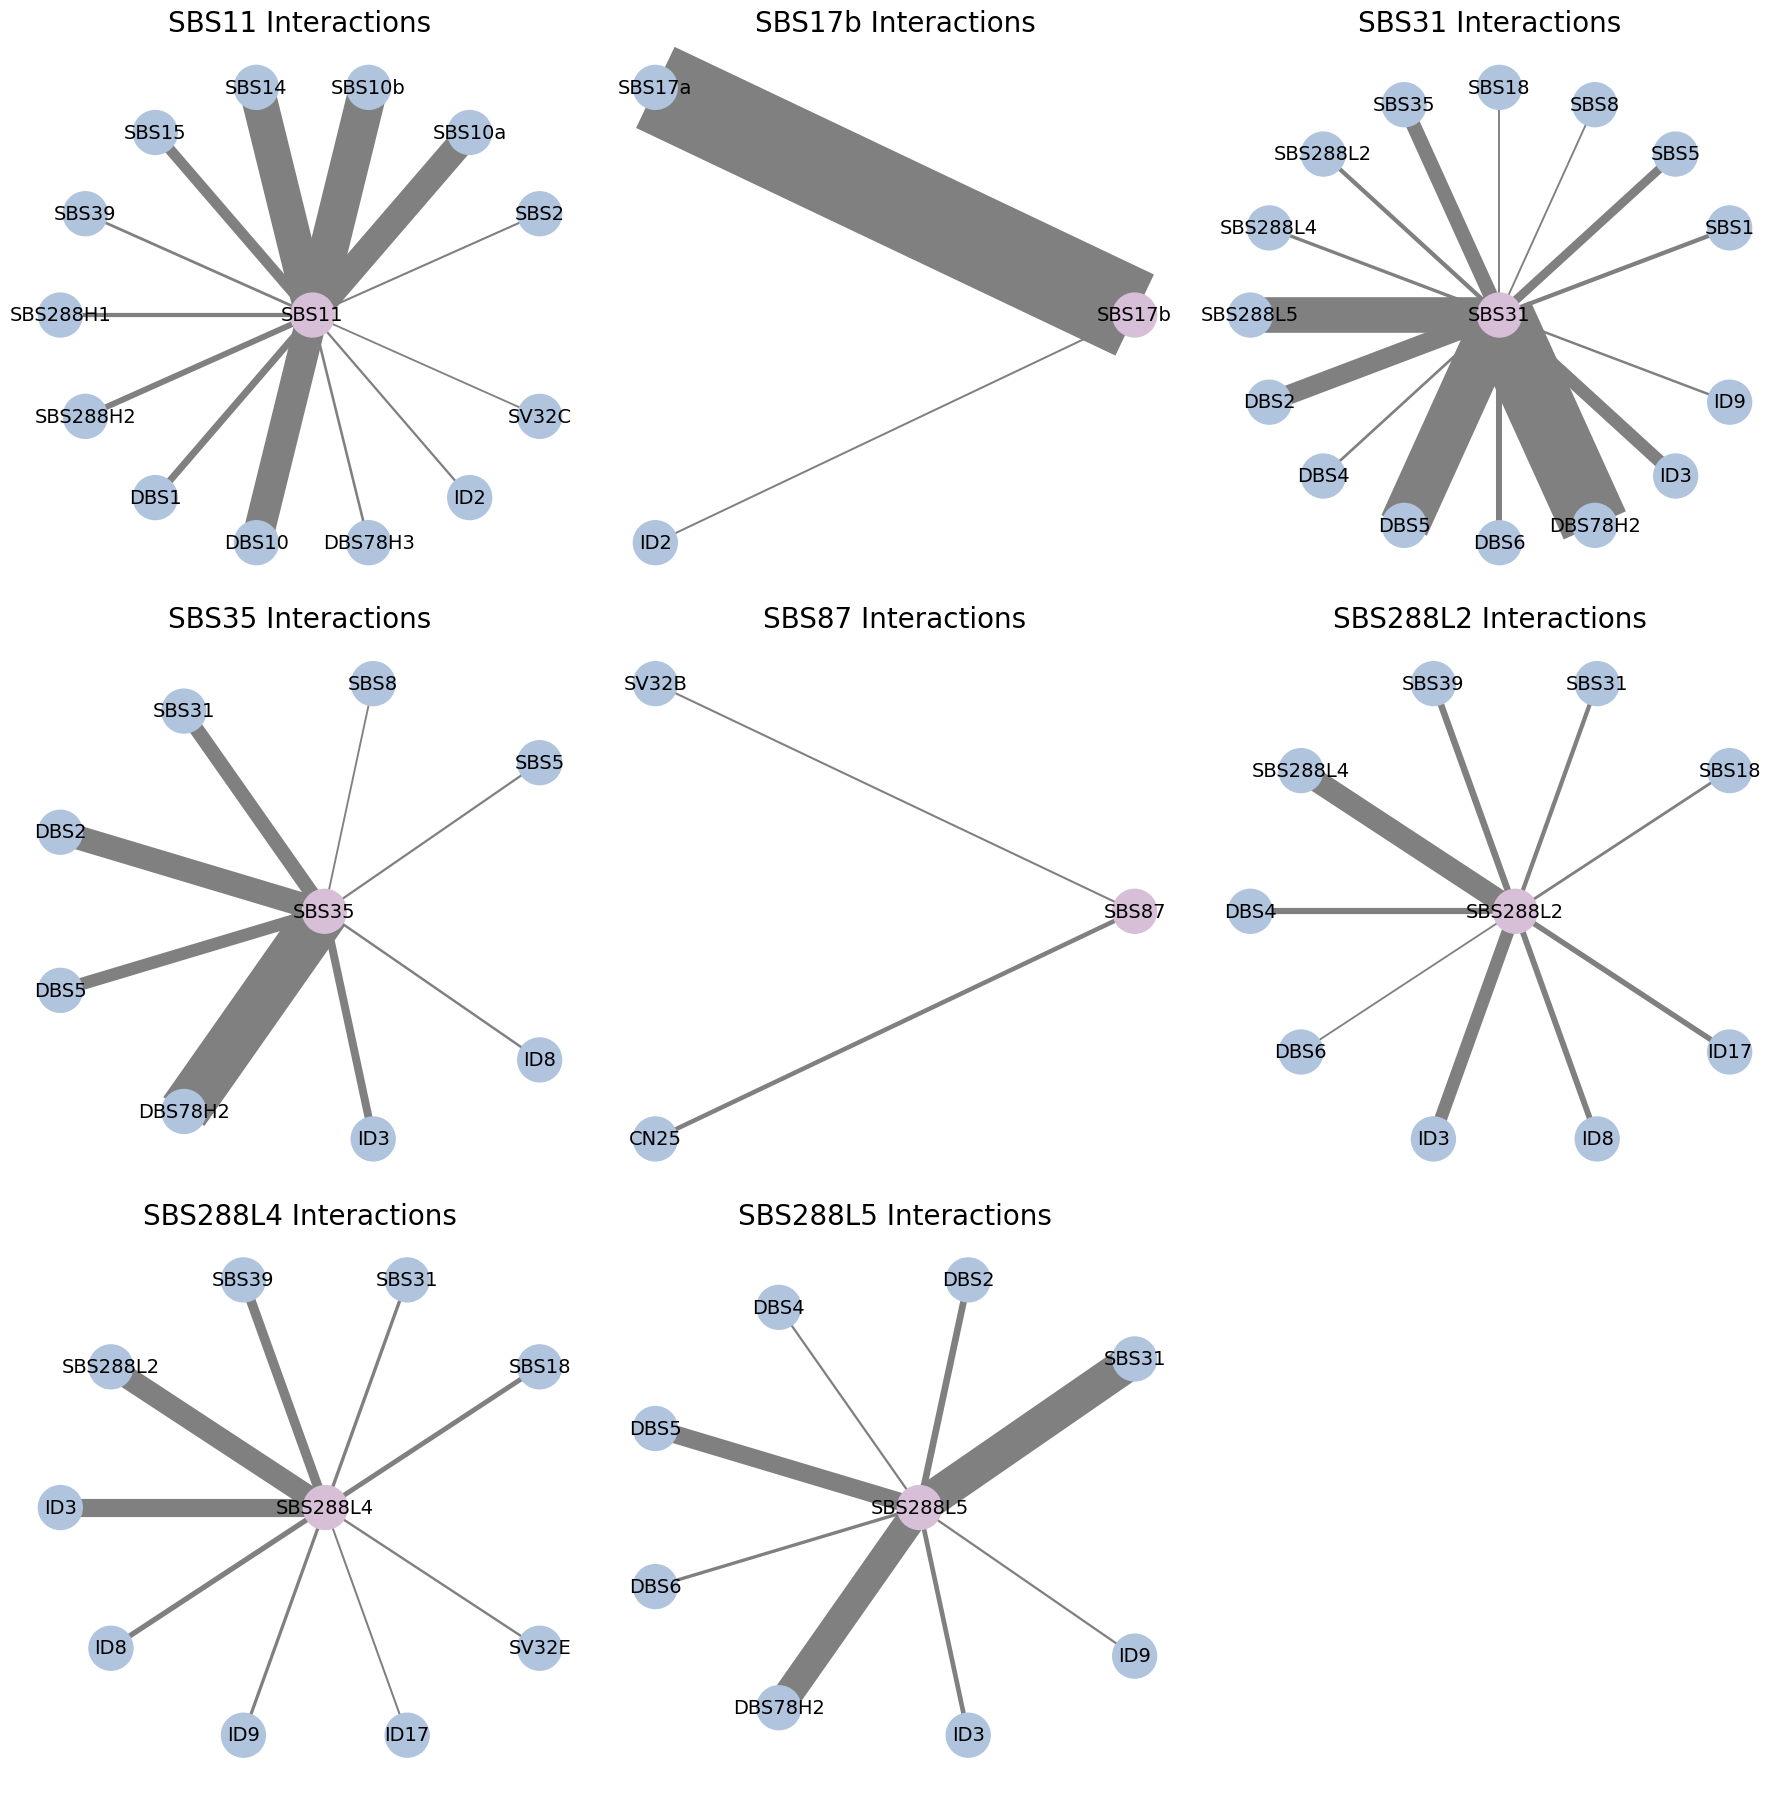

In [14]:
plotter.plot_bipartite_subs(interaction_mat_noArtifact.loc[[x for x in interaction_mat_noArtifact.index if x in sbs_cosigs]])
#plt.savefig(os.path.join(fig_out, 'sigs_co', 'SBS_all.pdf'), bbox_inches="tight")

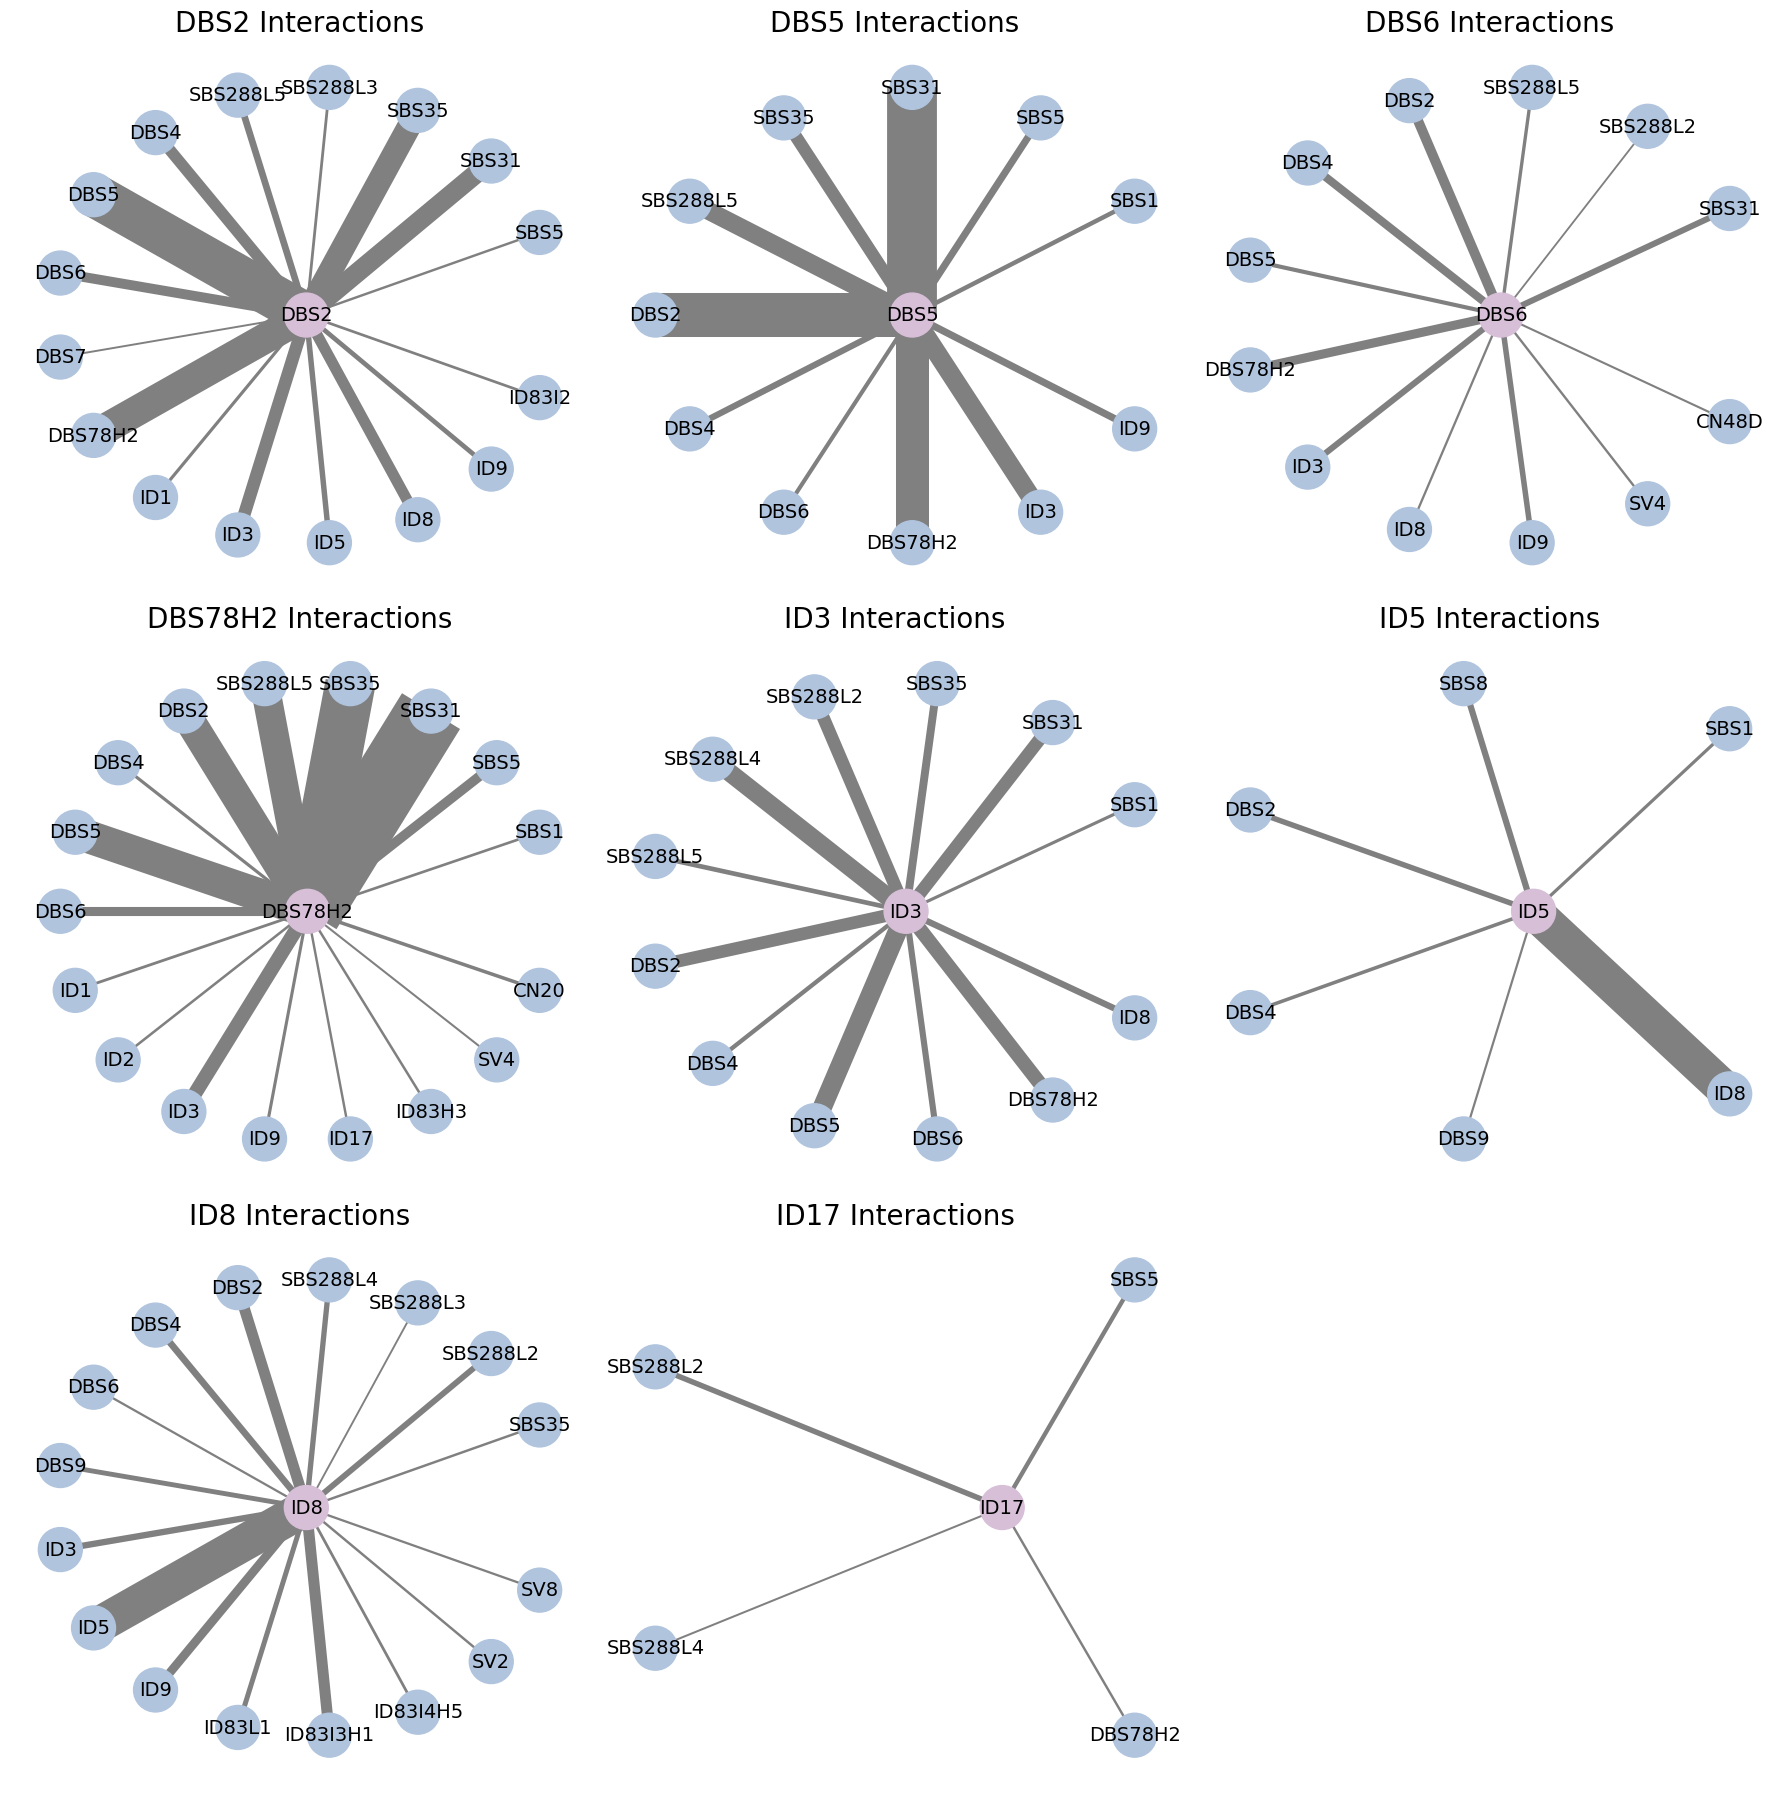

In [459]:
plotter.plot_bipartite_subs(interaction_mat_noArtifact.loc[[x for x in interaction_mat_noArtifact.index if x in dbs_cosigs]])
plt.savefig(os.path.join(fig_out, 'sigs_co', 'DBS_ID_all.pdf'), bbox_inches="tight")

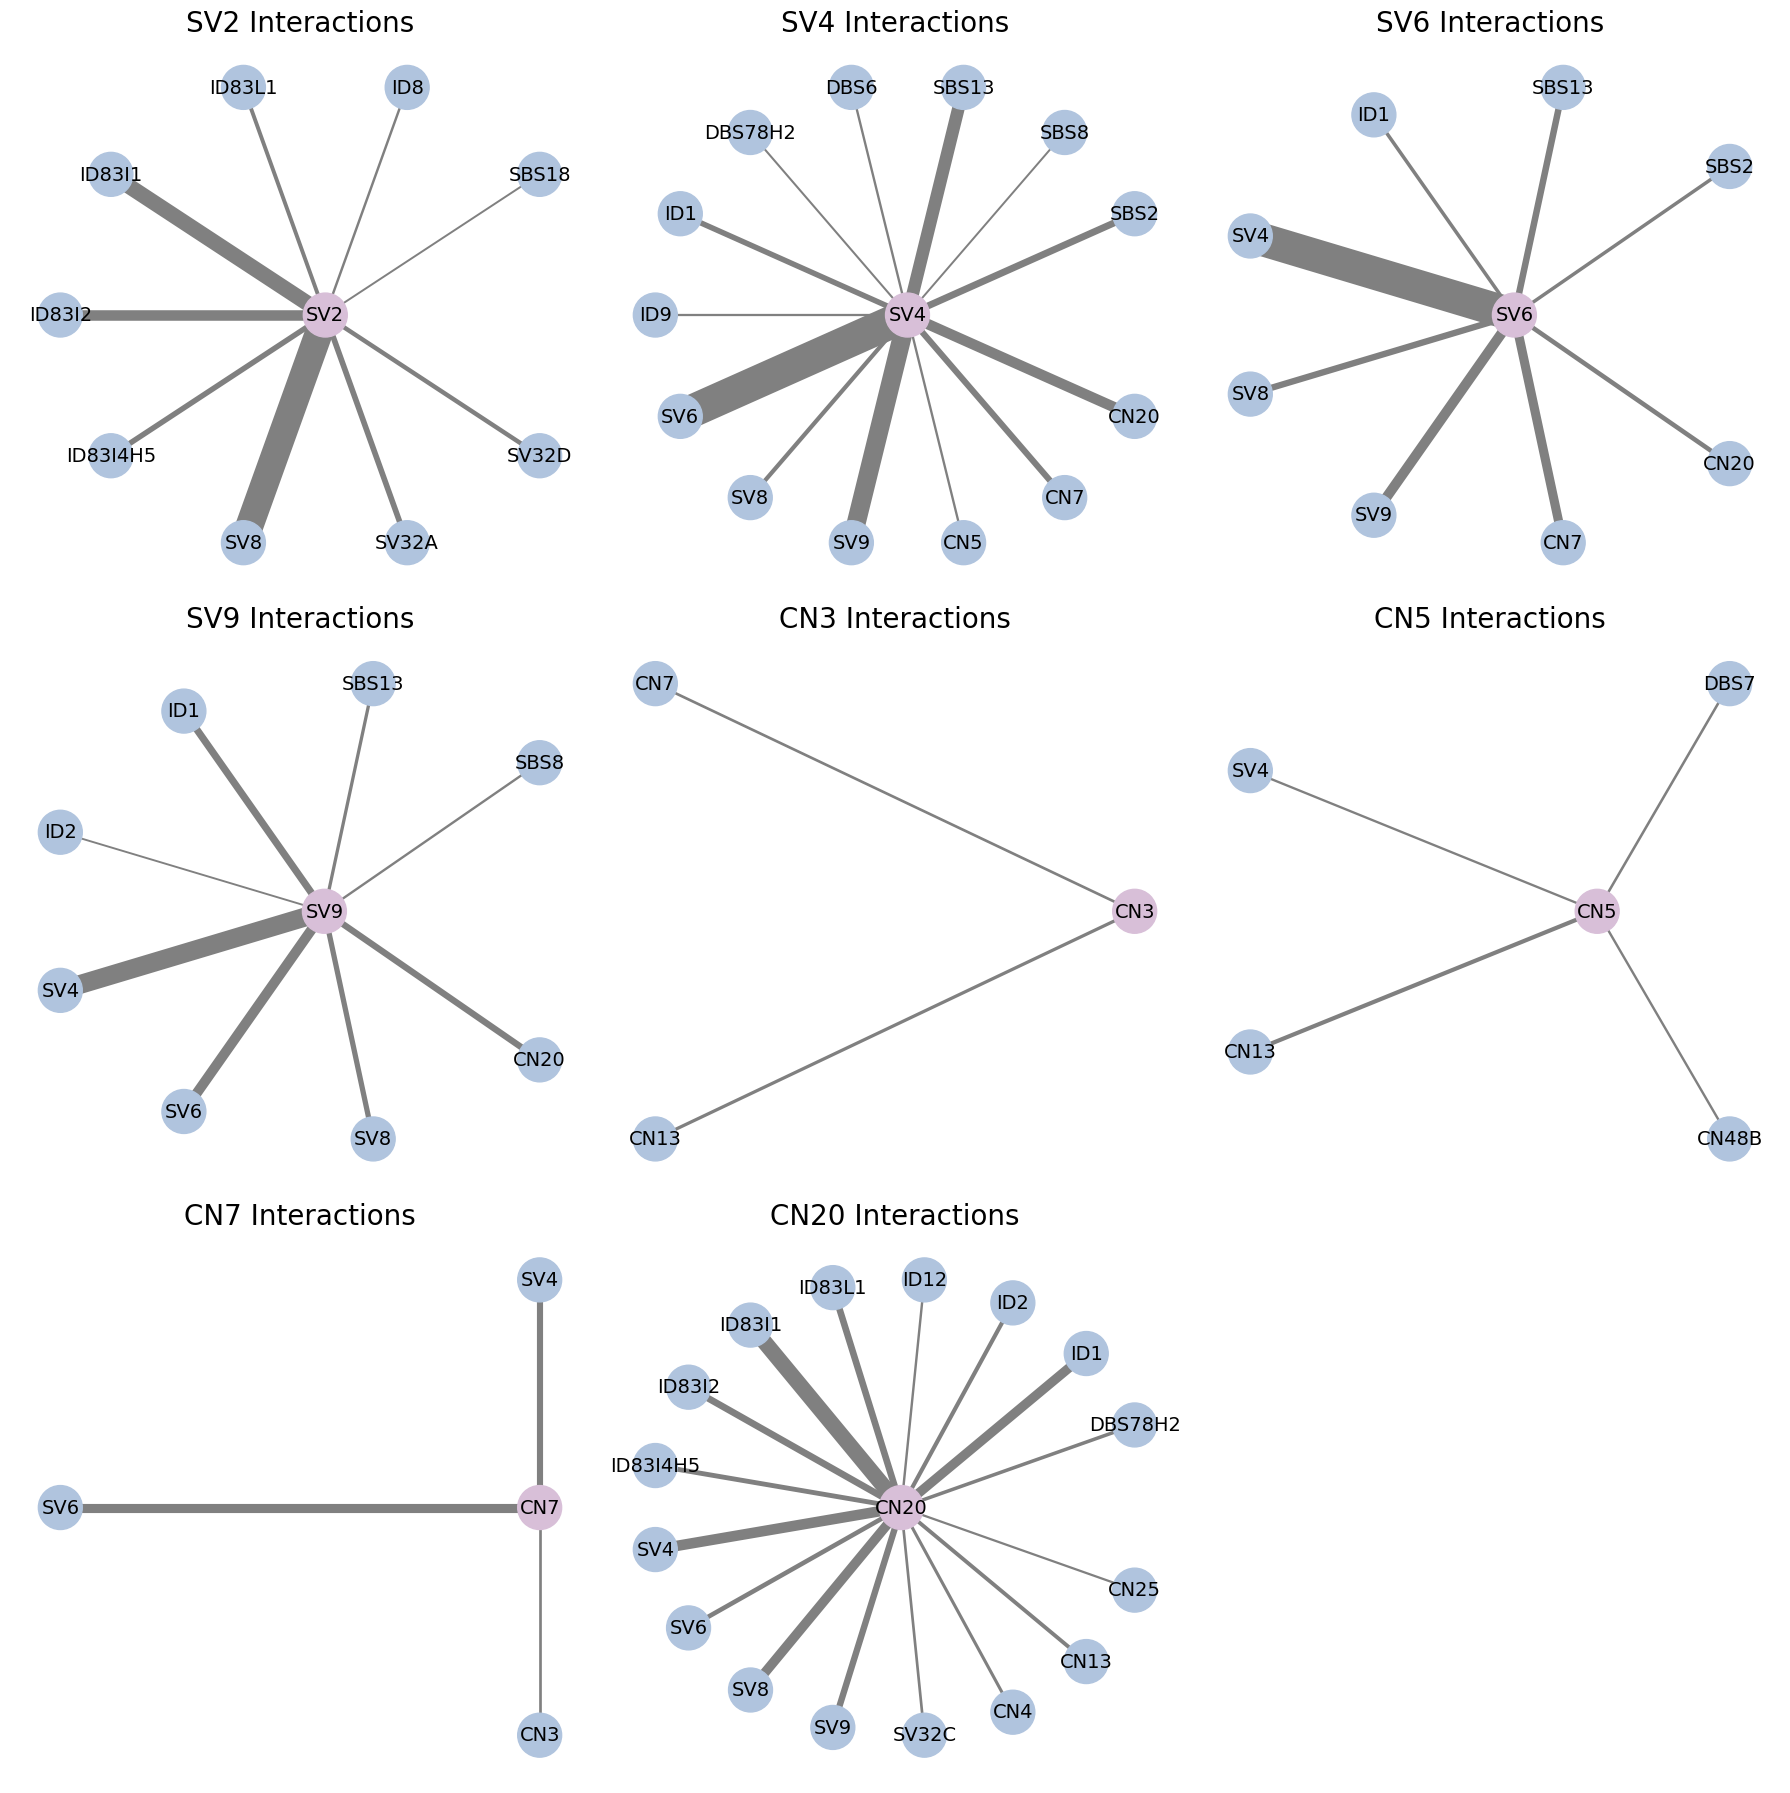

In [460]:
plotter.plot_bipartite_subs(interaction_mat_noArtifact.loc[[x for x in interaction_mat_noArtifact.index if x in svcn_cosigs]])
plt.savefig(os.path.join(fig_out, 'sigs_co', 'SVCN_all.pdf'), bbox_inches="tight")

-----------
## Supplementary Figure 4

In [ ]:
plat_sbs = ['SBS31', 'SBS35']
plat_dbs = ['DBS5']
plat_nov_sbs = ['SBS288L5']
plat_nov_dbs = ['DBS78H2']
thr_sbs = ['SBS11', 'SBS17b', 'SBS31', 'SBS35', 'SBS87']
thr_nov_sbs = ['SBS288L2', 'SBS288L3', 'SBS288L4', 'SBS288L5']
thr_dbs = ['SBS288L5']

In [ ]:
kzm611_sigs = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_signatures.tsv'), sep='\t', index_col=0)
kzm611_sigs_low = kzm611_sigs.loc[low_samples].copy()
kzm611_sigs.shape, kzm611_sigs_low.shape

((611, 70), (577, 70))

In [ ]:
kzm611_md_low = kzm611_md[kzm611_md.SBS_Burden=='low'].copy()
kzm611_sbs_low = kzm611_sigs_low[[x for x in kzm611_sigs_low.columns if x.startswith('SBS')]].copy()
kzm611_sbs = kzm611_sigs[[x for x in kzm611_sigs.columns if x.startswith('SBS')]].copy()


In [ ]:
kzm611_sbs2_thr = kzm611_sbs.copy()
burdens =  kzm611_sbs2_thr.sum(axis=1)
pn_burdens = [kzm611_sbs2_thr.loc[x].sum() if kzm611_md.loc[x, 'Thr_State']=='Primary-Naive' else 0 for x in kzm611_sbs2_thr.index]
at_burdens = [kzm611_sbs2_thr.loc[x].sum() if kzm611_md.loc[x, 'Thr_State']=='Advanced-Treated' else 0 for x in kzm611_sbs2_thr.index]
thr_burdens = kzm611_sbs2_thr[thr_sbs].sum(axis=1)

kzm611_sbs2_thr['Burden'] = burdens
kzm611_sbs2_thr['Primary-Naive'] = pn_burdens
kzm611_sbs2_thr['Thr-Sigs'] = thr_burdens
kzm611_sbs2_thr['Non-Thr'] = at_burdens - thr_burdens
kzm611_sbs2_thr['Advanced-Treated'] = at_burdens
kzm611_sbs2_thr['Advanced-Treated\n(minus thr SNVs)'] = kzm611_sbs2_thr['Advanced-Treated'] - kzm611_sbs2_thr['Thr-Sigs']

print(kzm611_sbs2_thr.shape[0])
kzm611_sbs2_thr = kzm611_sbs2_thr[(kzm611_sbs2_thr['Primary-Naive']>0) | kzm611_sbs2_thr['Advanced-Treated']>0]
print(kzm611_sbs2_thr.shape[0])

kzm611_sbs2_nov = kzm611_sbs.copy()
burdens =  kzm611_sbs2_nov.sum(axis=1)
pn_burdens = [kzm611_sbs2_nov.loc[x].sum() if kzm611_md.loc[x, 'Thr_State']=='Primary-Naive' else 0 for x in kzm611_sbs2_nov.index]
at_burdens = [kzm611_sbs2_nov.loc[x].sum() if kzm611_md.loc[x, 'Thr_State']=='Advanced-Treated' else 0 for x in kzm611_sbs2_nov.index]
thr_burdens = kzm611_sbs2_nov[thr_sbs+thr_nov_sbs].sum(axis=1)


kzm611_sbs2_nov['Burden'] = burdens
kzm611_sbs2_nov['Primary-Naive'] = pn_burdens
kzm611_sbs2_nov['Thr-Sigs'] = thr_burdens
kzm611_sbs2_nov['Non-Thr'] = at_burdens - thr_burdens
kzm611_sbs2_nov['Advanced-Treated'] = at_burdens
kzm611_sbs2_nov['Advanced-Treated\n(minus thr SNVs)'] = kzm611_sbs2_nov['Advanced-Treated'] - kzm611_sbs2_nov['Thr-Sigs']

print(kzm611_sbs2_nov.shape[0])
kzm611_sbs2_nov = kzm611_sbs2_nov[(kzm611_sbs2_nov['Primary-Naive']>0) | kzm611_sbs2_nov['Advanced-Treated']>0]
print(kzm611_sbs2_nov.shape[0])

kzm611_sbs2_nov.head()


611
505
611
505


,SBS1,SBS2,SBS5,SBS7a,SBS7b,SBS8,SBS10a,SBS10b,SBS11,SBS12,...,SBS288H1,SBS288H2,SBS288H4,SBS288H5,Burden,Primary-Naive,Thr-Sigs,Non-Thr,Advanced-Treated,Advanced-Treated\n(minus thr SNVs)
I-H-108298-T1-1-D1-1,0,0,2469,0,0,0,0,0,0,0,...,0,0,0,0,11170,0,1868,9302,11170,9302
I-H-108317-T1-1-D1-1,571,0,1695,0,0,989,0,0,0,0,...,0,0,0,0,3255,0,0,3255,3255,3255
I-H-108319-T1-1-D1-1,0,0,3600,0,0,0,0,0,0,0,...,0,0,0,0,10558,0,2833,7725,10558,7725
I-H-108333-T2-2-D1-1,434,0,2716,0,0,1254,0,0,0,0,...,0,0,0,0,4404,0,0,4404,4404,4404
I-H-133672-T1-2-D1-1,229,0,1313,0,0,0,0,0,0,0,...,0,0,0,0,2155,2155,0,0,0,0


In [ ]:
kzm611_sbs_low2_thr = kzm611_sbs_low.copy()
burdens =  kzm611_sbs_low2_thr.sum(axis=1)
pn_burdens = [kzm611_sbs_low2_thr.loc[x].sum() if kzm611_md_low.loc[x, 'Thr_State']=='Primary-Naive' else 0 for x in kzm611_sbs_low2_thr.index]
at_burdens = [kzm611_sbs_low2_thr.loc[x].sum() if kzm611_md_low.loc[x, 'Thr_State']=='Advanced-Treated' else 0 for x in kzm611_sbs_low2_thr.index]
thr_burdens = kzm611_sbs_low2_thr[thr_sbs].sum(axis=1)

kzm611_sbs_low2_thr['Burden'] = burdens
kzm611_sbs_low2_thr['Primary-Naive'] = pn_burdens
kzm611_sbs_low2_thr['Thr-Sigs'] = thr_burdens
kzm611_sbs_low2_thr['Non-Thr'] = at_burdens - thr_burdens
kzm611_sbs_low2_thr['Advanced-Treated'] = at_burdens
kzm611_sbs_low2_thr['Advanced-Treated\n(minus thr SNVs)'] = kzm611_sbs_low2_thr['Advanced-Treated'] - kzm611_sbs_low2_thr['Thr-Sigs']

print(kzm611_sbs_low2_thr.shape[0])
kzm611_sbs_low2_thr = kzm611_sbs_low2_thr[(kzm611_sbs_low2_thr['Primary-Naive']>0) | kzm611_sbs_low2_thr['Advanced-Treated']>0]
print(kzm611_sbs_low2_thr.shape[0])

kzm611_sbs_low2_nov = kzm611_sbs_low.copy()
burdens =  kzm611_sbs_low2_nov.sum(axis=1)
pn_burdens = [kzm611_sbs_low2_nov.loc[x].sum() if kzm611_md_low.loc[x, 'Thr_State']=='Primary-Naive' else 0 for x in kzm611_sbs_low2_nov.index]
at_burdens = [kzm611_sbs_low2_nov.loc[x].sum() if kzm611_md_low.loc[x, 'Thr_State']=='Advanced-Treated' else 0 for x in kzm611_sbs_low2_nov.index]
thr_burdens = kzm611_sbs_low2_nov[thr_sbs+thr_nov_sbs].sum(axis=1)

kzm611_sbs_low2_nov['Burden'] = burdens
kzm611_sbs_low2_nov['Primary-Naive'] = pn_burdens
kzm611_sbs_low2_nov['Thr-Sigs'] = thr_burdens
kzm611_sbs_low2_nov['Non-Thr'] = at_burdens - thr_burdens
kzm611_sbs_low2_nov['Advanced-Treated'] = at_burdens
kzm611_sbs_low2_nov['Advanced-Treated\n(minus thr SNVs)'] = kzm611_sbs_low2_nov['Advanced-Treated'] - kzm611_sbs_low2_nov['Thr-Sigs']

print(kzm611_sbs_low2_nov.shape[0])
kzm611_sbs_low2_nov = kzm611_sbs_low2_nov[(kzm611_sbs_low2_nov['Primary-Naive']>0) | kzm611_sbs_low2_nov['Advanced-Treated']>0]
print(kzm611_sbs_low2_nov.shape[0])

kzm611_sbs_low2_nov.head()


577
476
577
476


,SBS1,SBS2,SBS5,SBS7a,SBS7b,SBS8,SBS10a,SBS10b,SBS11,SBS12,...,SBS288H1,SBS288H2,SBS288H4,SBS288H5,Burden,Primary-Naive,Thr-Sigs,Non-Thr,Advanced-Treated,Advanced-Treated\n(minus thr SNVs)
KiCS0002_321321,105,0,0,0,0,0,0,0,0,0,...,0,0,0,0,15207,0,15102,105,15207,105
KiCS0003_285201,192,0,789,0,0,0,0,0,0,0,...,0,0,0,0,1596,0,0,1596,1596,1596
KiCS0003_285202,236,0,2507,0,0,0,0,0,0,0,...,0,0,0,0,3670,0,0,3670,3670,3670
KiCS0003_20_15220_A_02_00,941,0,6552,0,0,0,0,0,0,0,...,0,0,0,0,17044,0,7165,9879,17044,9879
KiCS0005_300238,0,0,125,0,0,0,0,0,0,0,...,0,0,0,0,125,125,0,0,0,0


In [ ]:
burden_mlt_low_thr = ut.sigs_melt(kzm611_sbs_low2_thr[['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)']].copy())
burden_mlt_low_nov = ut.sigs_melt(kzm611_sbs_low2_nov[['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)']].copy())

burden_mlt_low_thr.head()

,Samples,Signatures,Mutations
0,KiCS0002_321321,Primary-Naive,0
1,KiCS0003_285201,Primary-Naive,0
2,KiCS0003_285202,Primary-Naive,0
3,KiCS0003_20_15220_A_02_00,Primary-Naive,0
4,KiCS0005_300238,Primary-Naive,125


In [ ]:
burden_mlt_thr = ut.sigs_melt(kzm611_sbs2_thr[['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)']].copy())
burden_mlt_nov = ut.sigs_melt(kzm611_sbs2_nov[['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)']].copy())

burden_mlt_nov.head()

,Samples,Signatures,Mutations
0,I-H-108298-T1-1-D1-1,Primary-Naive,0
1,I-H-108317-T1-1-D1-1,Primary-Naive,0
2,I-H-108319-T1-1-D1-1,Primary-Naive,0
3,I-H-108333-T2-2-D1-1,Primary-Naive,0
4,I-H-133672-T1-2-D1-1,Primary-Naive,2155


In [ ]:

first	second	pv
0	0	1	1.897803e-01
1	0	2	9.111186e-01
2	0	3	3.052357e-11
3	1	2	7.934680e-01
4	1	3	1.620457e-03
5	2	3	1.897803e-01

In [ ]:
sbs_pvals = pd.DataFrame([[0,1,1],
                          [0,2,1],
                          [0,3,1],
                          [1,2,1],
                          [1,3,1],
                          [2,3,1]], columns=['first', 'second', 'pv'])
sbs_pvals

,first,second,pv
0,0,1,1
1,0,2,1
2,0,3,1
3,1,2,1
4,1,3,1
5,2,3,1


In [ ]:
## Define colors for plotting
color_dict = {'Primary-Naive': 'lightsteelblue', 'Thr-Sigs': 'mistyrose', 'Non-Thr': 'lightsteelblue', 'Advanced-Treated': 'mistyrose', 'Advanced-Treated\n(minus thr SNVs)': 'lightsteelblue'}

In [ ]:
from importlib import reload
reload(plotter)

<module 'scripts.plotter' from '/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py'>

/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:467: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:468: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(yaxis, fontsize=14)
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:470: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes2 = ax.twiny()
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:471

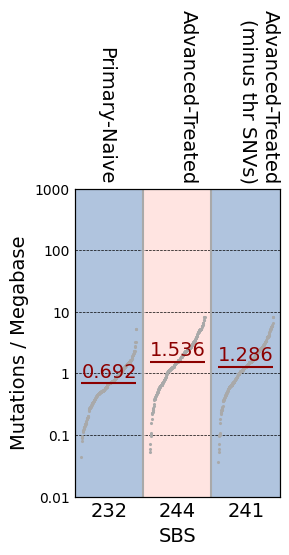

In [ ]:
plotter.plotTMB_therapy_v2(burden_mlt_low_thr[['Signatures', 'Mutations']].copy(), sbs_pvals, scale='genome',
                        color_dict=color_dict, order=['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)'],
                        xaxis="SBS", yaxis = "Mutations / Megabase", Yrange=[0.01, 1000])
plt.savefig(os.path.join(fig_out, 'SuppFig_3a_rev.pdf'), bbox_inches="tight")

/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:467: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:468: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(yaxis, fontsize=14)
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:470: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes2 = ax.twiny()
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:471

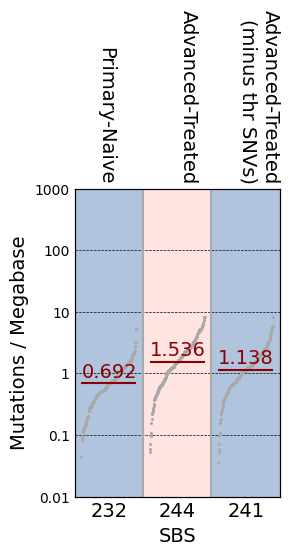

In [ ]:
plotter.plotTMB_therapy_v2(burden_mlt_low_nov[['Signatures', 'Mutations']].copy(), sbs_pvals, scale='genome',
                        color_dict=color_dict, order=['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)'],
                        xaxis="SBS", yaxis = "Mutations / Megabase", Yrange=[0.01, 1000])
plt.savefig(os.path.join(fig_out, 'SuppFig_3b_rev.pdf'), bbox_inches="tight")

/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:467: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:468: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(yaxis, fontsize=14)
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:470: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes2 = ax.twiny()
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:471

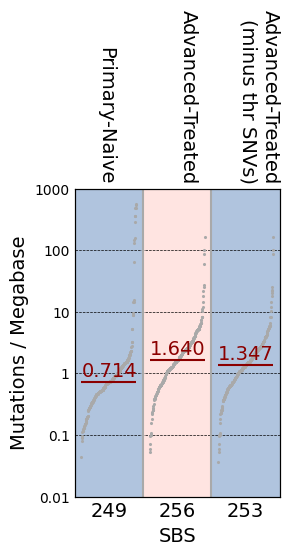

In [ ]:
plotter.plotTMB_therapy_v2(burden_mlt_thr[['Signatures', 'Mutations']].copy(), sbs_pvals, scale='genome',
                        color_dict=color_dict, order=['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)'],
                        xaxis="SBS", yaxis = "Mutations / Megabase", Yrange=[0.01, 1000])
plt.savefig(os.path.join(fig_out, 'SuppFig_3c_rev.pdf'), bbox_inches="tight")

/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:467: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:468: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(yaxis, fontsize=14)
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:470: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes2 = ax.twiny()
/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py:471

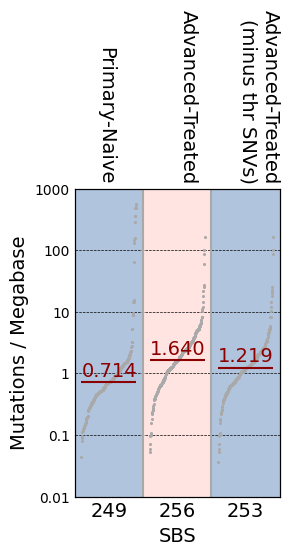

In [ ]:
plotter.plotTMB_therapy_v2(burden_mlt_nov[['Signatures', 'Mutations']].copy(), sbs_pvals, scale='genome',
                        color_dict=color_dict, order=['Primary-Naive', 'Advanced-Treated', 'Advanced-Treated\n(minus thr SNVs)'],
                        xaxis="SBS", yaxis = "Mutations / Megabase", Yrange=[0.01, 1000])
plt.savefig(os.path.join(fig_out, 'SuppFig_3d_rev.pdf'), bbox_inches="tight")

-----------
## Supplementary Figures 5-6

In [ ]:
logreg_coefs = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_drug_sigs_assocs.tsv'), sep='\t')
logreg_coefs.head()

,Features,Coefficient,Outcome,AUC,pvalue,Condition
0,SBS57,1.270805,TP53,0.800484,0.0,sbs_driver_noX_low
1,SBS8,1.183629,TP53,0.800484,0.0,sbs_driver_noX_low
2,SBS46,1.120452,TP53,0.800484,0.0,sbs_driver_noX_low
3,SBS1,1.110724,TP53,0.800484,0.0,sbs_driver_noX_low
4,SBS11,0.978337,TP53,0.800484,0.0,sbs_driver_noX_low


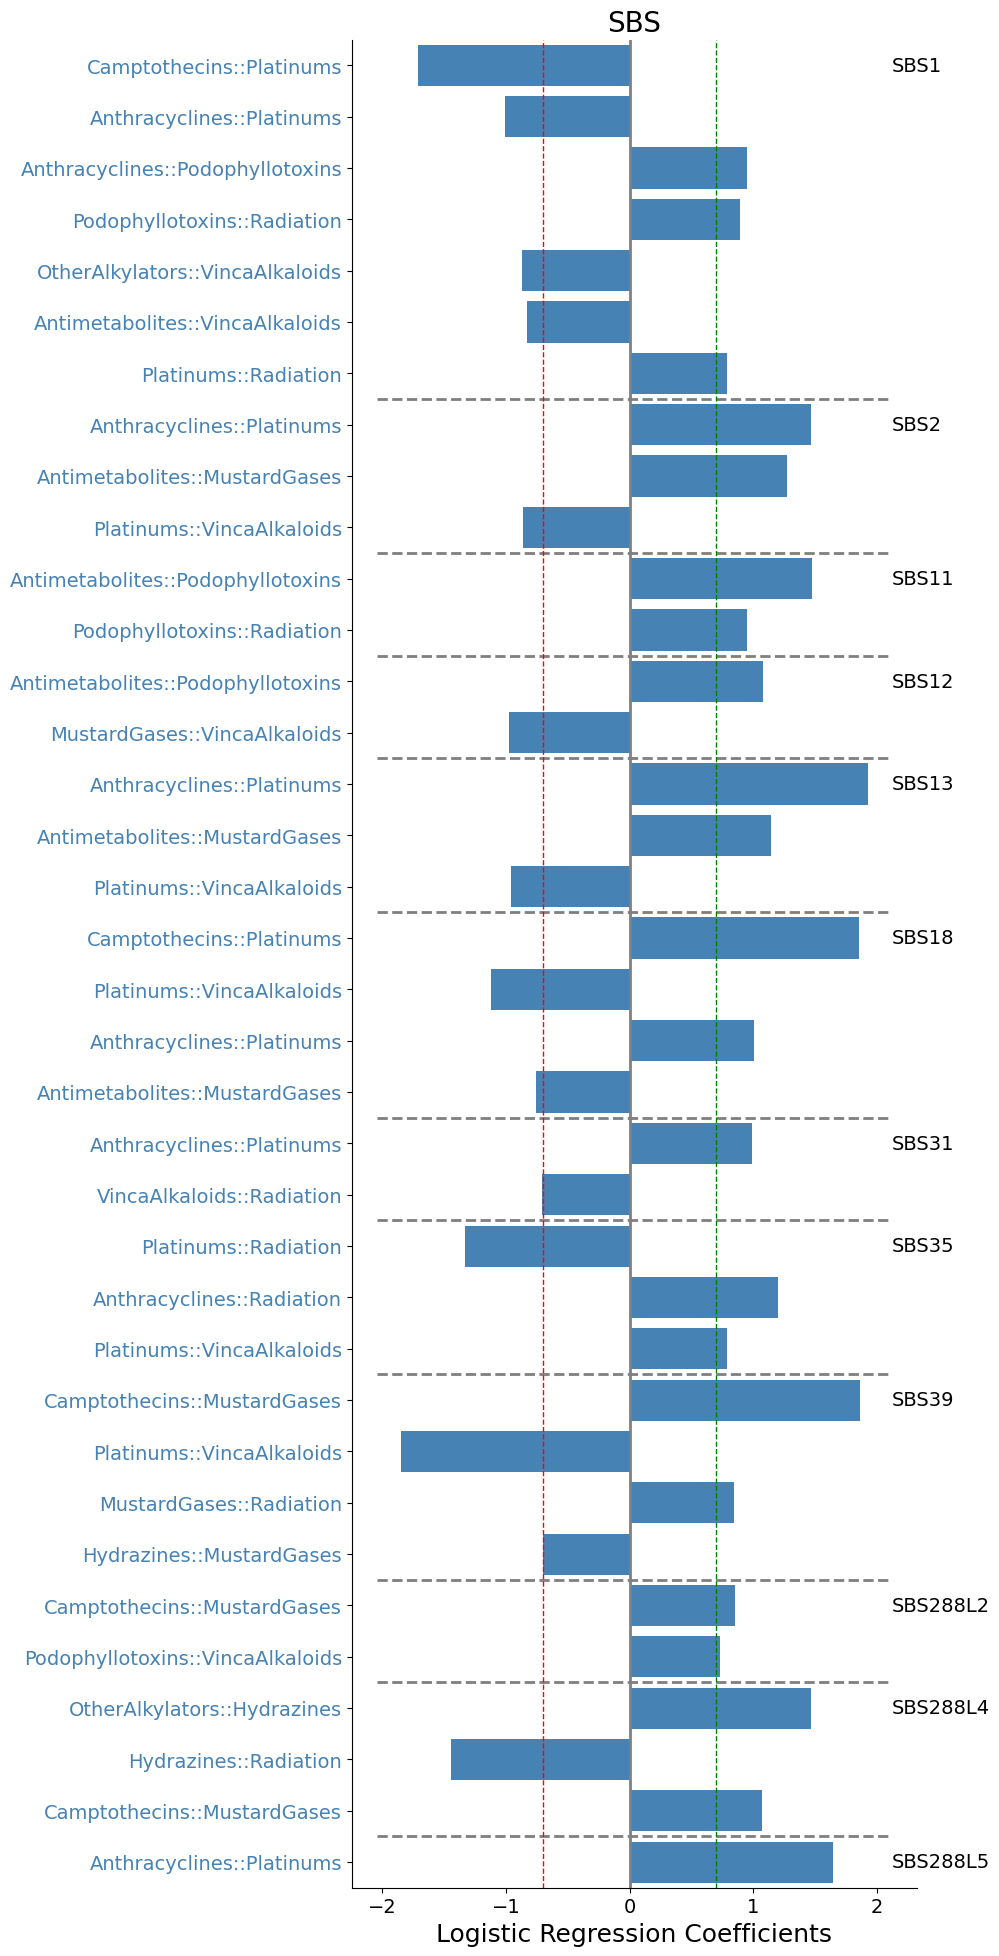

<Figure size 640x480 with 0 Axes>

In [ ]:
cond = 'class_sigs_X_all'
preds = cond.split('_')[0].upper()
outcome = cond.split('_')[1].title()
burden = cond.split('_')[-1].title()
burden = 'Low Burden' if burden == 'Low' else burden

sig = 'SBS'
subd = logreg_coefs[(logreg_coefs.Condition==cond) & (logreg_coefs.Outcome.isin([x for x in logreg_coefs.Outcome if x.startswith('SBS')]))]
subd = subd[subd.AUC>=0.7]

if len(subd) > 0:
    plotter.plot_coefs(subd, f'{sig}')
    plt.savefig(os.path.join(fig_out, f'{sig}_{cond}_X.pdf'), bbox_inches="tight")

In [ ]:
cond = 'agent_sigs_X_all'
preds = cond.split('_')[0].upper()
outcome = cond.split('_')[1].title()
burden = cond.split('_')[-1].title()
burden = 'Low Burden' if burden == 'Low' else burden

sig = 'SBS'
subd = logreg_coefs[(logreg_coefs.Condition==cond) & (logreg_coefs.Outcome.isin([x for x in logreg_coefs.Outcome if x.startswith('SBS')]))]
subd = subd[subd.AUC>=0.7]

if len(subd) > 0:
    plotter.plot_coefs(subd, f'{sig}')
    plt.savefig(os.path.join(fig_out, f'{sig}_{cond}_X.pdf'), bbox_inches="tight")
    plt.close()

In [ ]:
cond = 'class_sigs_X_all'
preds = cond.split('_')[0].upper()
outcome = cond.split('_')[1].title()
burden = cond.split('_')[-1].title()
burden = 'Low Burden' if burden == 'Low' else burden

sig = 'DBS and ID'
subd = logreg_coefs[(logreg_coefs.Condition==cond) & (logreg_coefs.Outcome.isin([x for x in logreg_coefs.Outcome if x.startswith('DBS') or x.startswith('ID')]))]
subd = subd[subd.AUC>=0.7]

if len(subd) > 0:
    plotter.plot_coefs(subd, f'{sig}')
    plt.savefig(os.path.join(fig_out, f'{sig}_{cond}_X.pdf'), bbox_inches="tight")
    plt.close()

In [ ]:
cond = 'agent_sigs_X_all'
preds = cond.split('_')[0].upper()
outcome = cond.split('_')[1].title()
burden = cond.split('_')[-1].title()
burden = 'Low Burden' if burden == 'Low' else burden

sig = 'DBS and ID'
subd = logreg_coefs[(logreg_coefs.Condition==cond) & (logreg_coefs.Outcome.isin([x for x in logreg_coefs.Outcome if x.startswith('DBS') or x.startswith('ID')]))]
subd = subd[subd.AUC>=0.7]

if len(subd) > 0:
    plotter.plot_coefs(subd, f'{sig}')
    plt.savefig(os.path.join(fig_out, f'{sig}_{cond}_X.pdf'), bbox_inches="tight")
    plt.close()

In [ ]:
cond = 'class_sigs_X_all'
preds = cond.split('_')[0].upper()
outcome = cond.split('_')[1].title()
burden = cond.split('_')[-1].title()
burden = 'Low Burden' if burden == 'Low' else burden

sig = 'SV and CN'
subd = logreg_coefs[(logreg_coefs.Condition==cond) & (logreg_coefs.Outcome.isin([x for x in logreg_coefs.Outcome if x.startswith('SV') or x.startswith('CN')]))]
subd = subd[subd.AUC>=0.7]

if len(subd) > 0:
    plotter.plot_coefs(subd, f'{sig}')
    plt.savefig(os.path.join(fig_out, f'{sig}_{cond}_X.pdf'), bbox_inches="tight")
    plt.close()

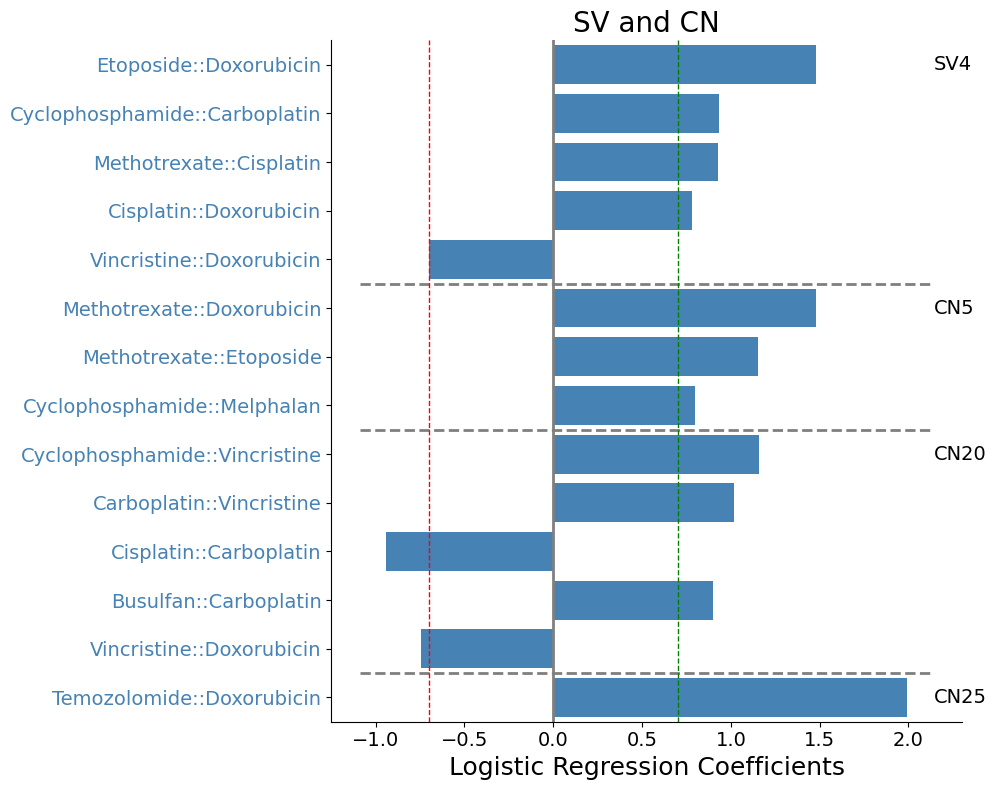

In [ ]:
cond = 'agent_sigs_X_all'
preds = cond.split('_')[0].upper()
outcome = cond.split('_')[1].title()
burden = cond.split('_')[-1].title()
burden = 'Low Burden' if burden == 'Low' else burden

sig = 'SV and CN'
subd = logreg_coefs[(logreg_coefs.Condition==cond) & (logreg_coefs.Outcome.isin([x for x in logreg_coefs.Outcome if x.startswith('SV') or x.startswith('CN')]))]
subd = subd[subd.AUC>=0.7]

if len(subd) > 0:
    plotter.plot_coefs(subd, f'{sig}')
    plt.savefig(os.path.join(fig_out, f'{sig}_{cond}_X.pdf'), bbox_inches="tight")
    plt.close()

-----------
## Supplementary Figure 9

### See MainFig_4

-----------
## Supplementary Figure 9

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import fisher_exact

# Data
labels = ['Signature-Positive vs.\nSignature-Negative', 
          'Signature-Positive vs.\nTreatment-Naive', 
          'Signature-Positive vs.\nPlatinum-Naive']

tables = [
    [[26, 13], [7, 26]],
    [[26, 13], [33, 61]],
    [[26, 13], [38, 46]]
]

# Compute OR and CI
odds_ratios = []
conf_intervals = []
p_values = []

for table in tables:
    odds_ratio, p_value = fisher_exact(table)
    a, b = table[0]
    c, d = table[1]

    # log OR standard error
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    ci_low = np.exp(np.log(odds_ratio) - 1.96 * se)
    ci_high = np.exp(np.log(odds_ratio) + 1.96 * se)

    odds_ratios.append(odds_ratio)
    conf_intervals.append((ci_low, ci_high))
    p_values.append(p_value)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
y_pos = np.arange(len(labels))[::-1]

for i, (or_val, ci, pval) in enumerate(zip(odds_ratios, conf_intervals, p_values)):
    ax.errorbar(or_val, y_pos[i], 
                xerr=[[or_val - ci[0]], [ci[1] - or_val]], 
                fmt='o', color='black', capsize=5)
    ax.text(ci[1] + 0.2, y_pos[i], f'p = {pval:.3g}', va='center', fontsize=9)

# Add vertical line at OR=1 (null)
ax.axvline(1, color='gray', linestyle='--')

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Odds Ratio (with 95% CI)')
ax.set_title('Enrichment of CX5')
ax.set_xlim(left=0.1)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
#plt.savefig(os.path.join('/Users/mehdi/Documents/MyRepos/mutsigs_therapy/figures', 'SuppFig_9_rev.pdf'), dpi=300, bbox_inches='tight')